# RNN(GNU) Classifier - 名字分类
![N6oFWA](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/N6oFWA.png)
- 训练一个RNN模型来将名字分类为对应的国家
    - 输入：一个字符串序列（名字）
    - 输出：
    - **注意：输入序列的长短是不一致的！**

![3LEwHw](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/3LEwHw.png)
![mfafrX](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/mfafrX.png)

In [1]:
import torch
import time
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
import gzip
import csv
import math
import matplotlib.pyplot as plt 
import numpy as np

## Paramters

In [2]:
HIDDEN_SIZE = 100 # 隐层数量
BATCH_SIZE = 256 
N_LAYER = 2 # GRU层数
N_EPOCHS = 100 
N_CHARS = 128 
USE_GPU = True

## Tools Function

In [3]:
# 输出训练时间
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# 在创建tensor时判断是否要用GPU
def create_tensor(tensor):
    if USE_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor

## Preparing Data
![PWjlFL](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/PWjlFL.png)
![yRc9Ve](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/yRc9Ve.png)
![0sEDlv](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/0sEDlv.png)


In [4]:
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = 'dataset/names/names_train.csv.gz' if is_train_set else 'dataset/names/names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f) 
            rows = list(reader) # 将读取到的文件内容转换为list
        self.names = [row[0] for row in rows] # 使用列表生成式生成名字list
        self.len = len(self.names) 
        self.countries = [row[1] for row in rows] # 使用列表生成式生成国籍list
        self.country_list = list(sorted(set(self.countries))) # 得到了去重、排序之后的国籍list
        self.country_dict = self.getCountryDict() # 构造国籍的词典
        self.country_num = len(self.country_list)
        
    # 使用索引得到的数据是 (姓名，国籍索引)
    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]]
    
    def __len__(self):
        return self.len
    
    # 构造国籍字典
    def getCountryDict(self):
        country_dict = dict() 
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx 
        return country_dict
    
    # 通过索引查询国籍名
    def idx2country(self, index):
        return self.country_list[index]
    
    # 获得样本中的国籍数目
    def getCountriesNum(self):
        return self.country_num

In [5]:
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) 
testset = NameDataset(is_train_set=False) 
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRY = trainset.getCountriesNum()

### 将名字转换为tensor的步骤
![dHPlJQ](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/dHPlJQ.png)
![mrqnKi](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/mrqnKi.png)
![7ACDVc](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/7ACDVc.png)
![uE7PXE](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/uE7PXE.png)
![XSgTV7](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/XSgTV7.png)


In [6]:
# 将名字转换为ascii列表
def name2list(name):
    arr = [ord(c) for c in name] # ord()返回对应的 ASCII 数值，或者 Unicode 数值
    return arr, len(arr)

In [7]:
# 转为tensor
def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names] 
    name_sequences = [sl[0] for sl in sequences_and_lengths] # name_sequences是姓名字符串转为的ASCII列表
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths]) 
    countries = countries.long()

    # make tensor of name, BatchSize x SeqLen
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long() # 先做一个全零的tensor
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0): # 将输入复制过去
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True) # 按序列长度进行排序
    # 输入序列和对应的国家都要按照这个顺序排序
    seq_tensor = seq_tensor[perm_idx] 
    countries = countries[perm_idx]

    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(countries)

## Model Design


In [8]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__() 
        self.hidden_size = hidden_size 
        self.n_layers = n_layers # GRU layers
        self.n_directions = 2 if bidirectional else 1 # 如果是双向的则为2

        self.embedding = torch.nn.Embedding(input_size, hidden_size) 
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, 
                                bidirectional=bidirectional) # bidirectional单向还是双向
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size) # hidden_size * self.n_directions表示拼接

    def _init_hidden(self, batch_size): # 创建全零的初始隐层
        hidden = torch.zeros(self.n_layers * self.n_directions, 
                             batch_size, self.hidden_size) 
        return create_tensor(hidden)
   
    def forward(self, input, seq_lengths):
        # input shape : B x S -> S x B
        input = input.t() # 转置transpose,把padding之后的数据变为竖的
        batch_size = input.size(1)
        
        hidden = self._init_hidden(batch_size) 
        embedding = self.embedding(input)

        # pack them up
        ## RNN，LSTM，GRU都可以接受pack_padded_sequence过的数据作为输入
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths)

        output, hidden = self.gru(gru_input, hidden) 
        if self.n_directions == 2:
            # 拼接两个隐藏的状态
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1) 
        else:
            hidden_cat = hidden[-1] 
        fc_output = self.fc(hidden_cat) 
        return fc_output

classifier = RNNClassifier(N_CHARS , HIDDEN_SIZE, 18)

### What is the Bi-Direction RNN/LSTM/GRU?
![IrYpso](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/IrYpso.png)
- 拼接正向和反向的隐藏层输出
最终输出的隐层输出如下：
![zGX0we](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/zGX0we.png)

### 为什么需要转置？
![gYUUtX](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/gYUUtX.png)

### pack_padded_sequence(embedding, seq_lengths)的作用
![ZeXgqU](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/ZeXgqU.png)
- pack_padded_sequence(embedding, seq_lengths)：
    - The first parameter with shape:（𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒, ℎ𝑖𝑑𝑑𝑒𝑛𝑆𝑖𝑧𝑒）
    - The second parameter is a tensor, which is a list of sequence length of each batch element.
    - It returns a PackedSquence object.

![fpMKUf](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/fpMKUf.png)
![wUM7n1](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/wUM7n1.png)
![htalH6](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/htalH6.png)


## Training & Test

In [9]:
def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries) 
        output = classifier(inputs, seq_lengths) 
        loss = criterion(output, target) 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() 
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end='') 
            print(f'[{i * len(inputs)}/{len(trainset)}] ', end='') 
            print(f'loss={total_loss / (i * len(inputs))}')
    return total_loss

In [10]:
def testModel():
    correct = 0 
    total = len(testset) 
    print("evaluating trained model ...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries) 
            output = classifier(inputs, seq_lengths) 
            pred = output.max(dim=1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        percent = '%.2f' % (100 * correct / total) 
        print(f'Test set: Accuracy {correct}/{total} {percent}%')
    return correct / total

## Main Function

In [11]:
if __name__ == '__main__':
    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)
    # 是否使用GPU
    if USE_GPU:
        device = torch.device("cuda:0")
        classifier.to(device)
    # 构造损失函数和优化器
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    start = time.time() 
    print("Training for %d epochs..." % N_EPOCHS) 
    acc_list = []
    epoch_list = []
    
    for epoch in range(1, N_EPOCHS + 1):
        # Train cycle，训练和测试封装在不同的函数中
        trainModel() 
        acc = testModel() 
        acc_list.append(acc)
        epoch_list.append(epoch)

Training for 100 epochs...
 0s] Epoch 1 [2560/13374] loss=0.008831825572997332
 0s] Epoch 1 [5120/13374] loss=0.007599199074320495
 0s] Epoch 1 [7680/13374] loss=0.006925769538308184
 0s] Epoch 1 [10240/13374] loss=0.00644455156289041
 0s] Epoch 1 [12800/13374] loss=0.006090904558077454
evaluating trained model ...
Test set: Accuracy 4443/6700 66.31%
 1s] Epoch 2 [2560/13374] loss=0.0042732032015919685
 1s] Epoch 2 [5120/13374] loss=0.00411197041394189
 1s] Epoch 2 [7680/13374] loss=0.003994902479462326
 1s] Epoch 2 [10240/13374] loss=0.0039050370862241833
 1s] Epoch 2 [12800/13374] loss=0.0038240877352654933
evaluating trained model ...
Test set: Accuracy 4909/6700 73.27%
 2s] Epoch 3 [2560/13374] loss=0.0033062070375308394
 2s] Epoch 3 [5120/13374] loss=0.003286694409325719
 2s] Epoch 3 [7680/13374] loss=0.003147212532348931
 2s] Epoch 3 [10240/13374] loss=0.0030934260110370817
 2s] Epoch 3 [12800/13374] loss=0.0030627458496019244
evaluating trained model ...
Test set: Accuracy 5200/

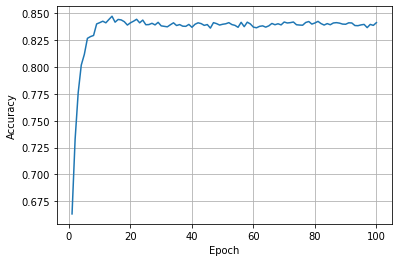

In [12]:
acc_list = np.array(acc_list) 
plt.plot(epoch_list, acc_list) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.grid()
plt.show()

从图中看最好的训练轮数在20左右